In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam

import keras_tuner as kt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Getting Data

In [2]:
train_data_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
train_data_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test_data_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
test_data_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_data = test_data_df.to_numpy()
print(f'Type of the test_data container: {type(test_data)}')
print(f'Shape of the test_data array: {test_data.shape}')

Type of the test_data container: <class 'numpy.ndarray'>
Shape of the test_data array: (28000, 784)


# Data Understanding

In [5]:
train_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


## Extract labels

In [6]:
train_data_labels = train_data_df.iloc[:,0].to_numpy()
print(f'Type of the labels container: {type(train_data_labels)}')
print(f'Shape of the labels array: {train_data_labels.shape}')

Type of the labels container: <class 'numpy.ndarray'>
Shape of the labels array: (42000,)


## Extract features

In [7]:
train_data = train_data_df.iloc[:, 1:].to_numpy()
print(f'Type of the features container: {type(train_data)}')
print(f'Shape of the features array: {train_data.shape}')

Type of the features container: <class 'numpy.ndarray'>
Shape of the features array: (42000, 784)


## Display image for better intuition about data

In [8]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis("off")

Digit - 8


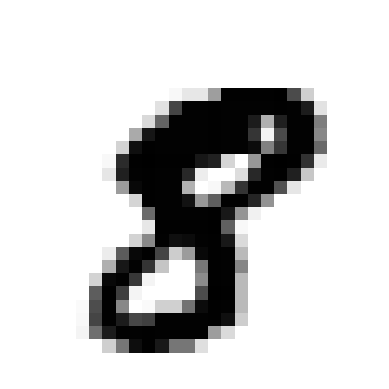

In [9]:
digit = train_data[10]
print(f'Digit - {train_data_labels[10]}')

plot_digit(digit)
plt.show()

Display first 100 digits from the training dataset.

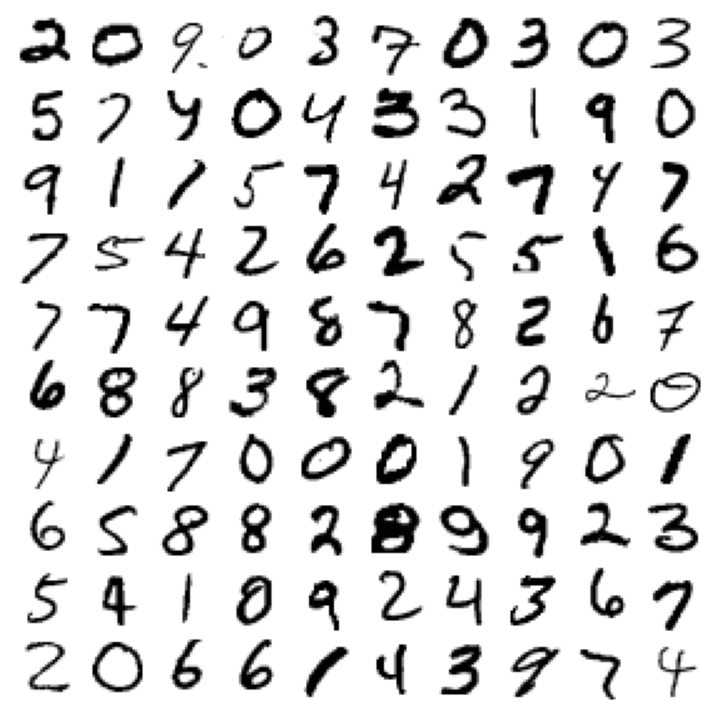

In [10]:
plt.figure(figsize=(9,9))
for i, image_data in enumerate(test_data[:100]):
    plt.subplot(10, 10, i+1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Reshape and normalize data

We need to reshape numpy array of the data to have the next shape - (batch_size, image_rows, image_cols, color_bytes).

**color_bytes** dimension represents RGB color. Black/white in our case.
So, for the current dataset it should be (42000, 28, 28, 1)

In [11]:
def reshape_and_normalize(data):
    data = np.reshape(data, (data.shape[0], 28, 28, 1))
    data = np.divide(data, 255)
    
    return data

In [12]:
# transform test dataset
test_data = reshape_and_normalize(test_data)
print(f'Shape of the test features: {test_data.shape}')

Shape of the test features: (28000, 28, 28, 1)


## Split train dataset into train and validation

In [13]:
VALIDATION_SIZE = 0.1

In [14]:
X_train, X_val, y_train, y_val = train_test_split(train_data, train_data_labels, test_size=VALIDATION_SIZE, random_state=42)

print(f'Train data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')

Train data shape: (37800, 784)
Validation data shape: (4200, 784)


## Image Data Generators

In [15]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels, classes_num):
    training_images = np.reshape(training_images, (training_images.shape[0], 28, 28, 1))
    validation_images = np.reshape(validation_images, (validation_images.shape[0], 28, 28, 1))

    # train data generator
    train_datagen = ImageDataGenerator(rescale=1/255,
                                       rotation_range=10,
                                       shear_range=0.1,
                                       zoom_range=0.1,
                                       width_shift_range=0.1,
                                       height_shift_range=0.1)

    train_labels_cat = to_categorical(training_labels, classes_num)
    train_generator = train_datagen.flow(x=training_images,
                                       y=train_labels_cat,
                                       batch_size=128)
    
    # validation data generator
    validation_datagen = ImageDataGenerator(rescale=1/255)
    validation_labels_cat = to_categorical(validation_labels, classes_num)
    validation_generator = validation_datagen.flow(x=validation_images,
                                                 y=validation_labels_cat,
                                                 batch_size=128)

    return train_generator, validation_generator

In [16]:
#generators
train_generator, validation_generator = train_val_generators(X_train, y_train, X_val, y_val, 10)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

Images of training generator have shape: (37800, 28, 28, 1)
Labels of training generator have shape: (37800, 10)
Images of validation generator have shape: (4200, 28, 28, 1)
Labels of validation generator have shape: (4200, 10)


# Model Training

In [17]:
def plot_model_history(history):
    # Plot the chart for accuracy and loss on both training and validation
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [18]:
def stratified_cross_validation(data, labels, k=5, batch_size=50):
    # Create a KFold object.
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    accuracy_scores = []
    loss_scores = []
    
    # Iterate over the folds.
    for train_index, validation_index in kfold.split(data, labels):
        # Get the train and test data.
        train_data = data[train_index]
        train_labels = labels[train_index]
        validation_data = data[validation_index]
        validation_labels = labels[validation_index]

        # Create model
        model = create_model()
        
        # Train the model on the train data.
        history = model.fit(train_data, train_labels, validation_data = (validation_data, validation_labels), epochs=10, batch_size=batch_size)

        # Plot accuracy and loss history
        plot_model_history(history)
        
        # Evaluate the model on the test data.
        loss, accuracy = model.evaluate(validation_data, validation_labels, verbose=0)
        print("Fold loss:", loss)
        print("Fold accuracy:", accuracy)
        
        # Store the evaluation metrics
        accuracy_scores.append(accuracy)
        loss_scores.append(loss)

    # Print the average accuracy.
    mean_loss = np.mean(loss_scores)
    mean_accuracy = np.mean(accuracy_scores)
    
    print("Average loss:", mean_loss)
    print("Average accuracy:", mean_accuracy)

In [19]:
#stratified_cross_validation(train_data, train_data_labels, 3)

## Model tuner

In [20]:
def build(hp):
    model = Sequential()
    model.add(Conv2D(64, (3,3), activation=tf.nn.relu, input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, (3,3), activation=tf.nn.relu))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(units=hp.Int("units", min_value=128, max_value=512, step=64),
              activation=tf.nn.relu))

    if hp.Boolean("dropout"):
        model.add(Dropout(rate=0.2))

    model.add(Dense(10, activation=tf.nn.softmax))

    model.compile(optimizer='adam',
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [21]:
def tuner_search():
    tuner = kt.RandomSearch(
        build,
        objective="val_accuracy",
        max_trials=5,
        overwrite=True,
        directory="my_dir",
        project_name="tune_hypermodel",
    )

    # Will stop training if the "val_loss" hasn't improved in 3 epochs.
    tuner.search(X_train, y_train, validation_data = (X_val, y_val), epochs=30, callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)])
    
    return tuner

In [22]:
#tuner_search()
#tuner.results_summary()

## Custom training

In [23]:
def create_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [24]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 12, 12, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 128)       7

In [25]:
history = model.fit(train_generator, validation_data = validation_generator, epochs=30)

Epoch 1/30
296/296 [==============================] - 161s 536ms/step - loss: 0.3917 - accuracy: 0.8816 - val_loss: 0.9945 - val_accuracy: 0.6610
Epoch 2/30
296/296 [==============================] - 158s 535ms/step - loss: 0.1095 - accuracy: 0.9672 - val_loss: 0.0514 - val_accuracy: 0.9829
Epoch 3/30
296/296 [==============================] - 158s 534ms/step - loss: 0.0831 - accuracy: 0.9751 - val_loss: 0.0507 - val_accuracy: 0.9857
Epoch 4/30
296/296 [==============================] - 158s 534ms/step - loss: 0.0715 - accuracy: 0.9793 - val_loss: 0.0254 - val_accuracy: 0.9917
Epoch 5/30
296/296 [==============================] - 160s 539ms/step - loss: 0.0589 - accuracy: 0.9826 - val_loss: 0.0322 - val_accuracy: 0.9914
Epoch 6/30
296/296 [==============================] - 157s 529ms/step - loss: 0.0576 - accuracy: 0.9838 - val_loss: 0.0370 - val_accuracy: 0.9890
Epoch 7/30
296/296 [==============================] - 157s 529ms/step - loss: 0.0501 - accuracy: 0.9857 - val_loss: 0.0532 -

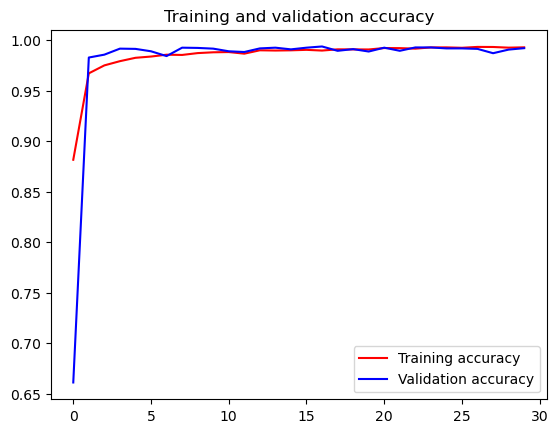

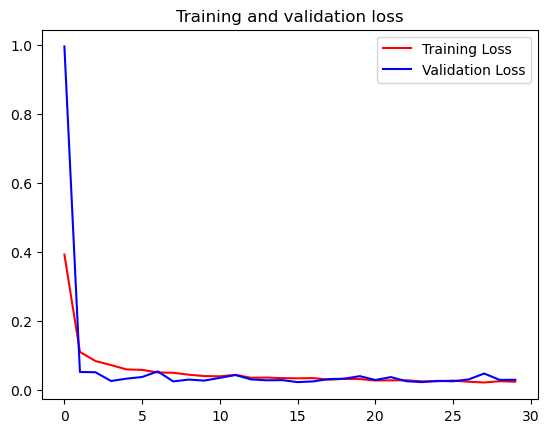

In [26]:
plot_model_history(history)

# Test data predictions

In [27]:
probabilities = model.predict(test_data)

875/875 [==============================] - 28s 32ms/step


In [28]:
predictions = np.argmax(probabilities, axis=1)

In [29]:
ids = np.arange(1, len(predictions) + 1)

In [30]:
output = pd.DataFrame({'ImageId': ids, 'Label': predictions})

In [31]:
output

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [32]:
output.to_csv('submission.csv', index=False)